# Local Covid-19 Metrics

## Gather Datasets

In [66]:

# init
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pandas import DataFrame

# set parameters
days_back = 90

# get content from web APIs
us = requests.get('https://covidtracking.com/api/v1/us/daily.json')
us = us.text
us = pd.read_json(us)

pa = requests.get('https://covidtracking.com/api/v1/states/pa/daily.json')
pa = pa.text
pa = pd.read_json(pa)

nj = requests.get('https://covidtracking.com/api/v1/states/nj/daily.json')
nj = nj.text
nj = pd.read_json(nj)

# we can only get the past 7 days for bucks county with this API
bucks_data = requests.get('https://localcoviddata.com/covid19/v1/cases/newYorkTimes?zipCode=19067&daysInPast=7')
bucks_data = bucks_data.text
bucks_data = pd.read_json(bucks_data)
bucks_data = bucks_data.counties[0].get("historicData")
bucks_data = DataFrame (bucks_data,columns=['date','deathCt','positiveCt'])
bucks_data['date'] = pd.to_datetime(pd.Series(bucks_data['date']), format="%Y-%m-%d")

# derive positive and death for bucks
diff = bucks_data[['deathCt','positiveCt']].diff(periods=-1)
bucks = bucks_data.join(diff, lsuffix='_caller', rsuffix='_other')
bucks = bucks.rename(columns={'deathCt_caller':'death_total'
                      ,'positiveCt_caller':'positive_total'
                      ,'deathCt_other':'death'
                      ,'positiveCt_other':'positive'})

# massage datasets

# make function for the covid tracking api since they are all the same
def clean_covidtracking_api_data(df):
    
    # get subset
    df = df[['date','positiveIncrease','totalTestResultsIncrease'
           ,'hospitalizedCurrently','death','deathIncrease','positive']]
    
    # Rename dataset columns
    df = df.rename(columns={'positiveIncrease':'positive'
                              ,'totalTestResultsIncrease': 'tests'
                              ,'hospitalizedCurrently': 'hospitalized'
                              ,'death': 'death_total'
                              ,'deathIncrease': 'death'
                              ,'positive': 'positive_total'})
    
    # Harmonize date column
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(pd.Series(df['date']), format="%Y%m%d")
    
    # Derived Columns
    # Positivity Rate
    positive = df.loc[:,['positive']].values[0:]
    tests = df.loc[:,['tests']].values[0:]
    df['pos_rate'] = positive / tests * 100

    # Death Rate
    deaths = df.loc[:,['death_total']].values[0:]
    positive = df.loc[:,['positive_total']].values[0:]
    df['death_rate'] = (deaths / positive) * 100
    df['death_rate_est'] = (deaths / (positive * 10)) * 100
    
    return df

# fix individual files
pa = clean_covidtracking_api_data(pa)
nj = clean_covidtracking_api_data(nj)
us = clean_covidtracking_api_data(us)

# Make compact summary dataset
a = pa[['date','positive','pos_rate','hospitalized']]
b = nj[['date','positive','pos_rate','hospitalized']]
pa_nj_positive = a.set_index('date').join(b.set_index('date'), lsuffix='_pa', rsuffix='_nj')

# Bucks death rate as of August 8, 2020
bucks_case_rate = 7118/626370*100000




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


## NOTES

Facts: 
- NJ has about 8.8 million people
- PA has about 12.5 million people
- Bucks County has 626,370 people
- WHO recommends opening schools for in person learning when your area has a positivity rate of no more than 5% for seven days

By mid-August
- PA had 953 cases per 100,000 people
- NY had 2,157 cases per 100,000 people
- NJ had 2,072 cases per 100,000 people
- Bucks had 1,136 cases per 100,000 people

In late summer:
- Bucks had an average of less than one death per day
- Bucks had about 30 new positive cases per day
- PA had an average positivity rate of 5.5%
- NJ had an average positivity rate of about 2%
- PA had a confirmed infection rate of 0.954%
- Bucks had a confirmed infection rate of 0.0114%

* NOTE experts believe that at least 10% of the population has an undiagnosed case of Covid-19. So if bucks has a confirmed infection rate of 0.0114 then we can assume that 0.114% of the Bucks County has been infected.

## PA and NJ Summary

In [67]:
pa_nj_positive.head()

,positive_pa,pos_rate_pa,hospitalized_pa,positive_nj,pos_rate_nj,hospitalized_nj
date,,,,,,
2020-08-07,758,4.553099,651.0,360,1.596665,551.0
2020-08-06,807,5.197733,663.0,374,0.865200,754.0
2020-08-05,705,5.342528,639.0,357,1.616701,784.0
2020-08-04,854,5.708556,656.0,356,100.000000,470.0
2020-08-03,565,4.708333,585.0,264,1.411614,738.0


## Bucks Summary

In [68]:
bucks.head()

,date,death_total,positive_total,death,positive
0,2020-08-06,581,7118,1.0,33.0
1,2020-08-05,580,7085,0.0,29.0
2,2020-08-04,580,7056,1.0,36.0
3,2020-08-03,579,7020,0.0,25.0
4,2020-08-02,579,6995,1.0,36.0


In [69]:

# change political entity dataset to select visualizations
# (stopgap for now until we have better organized data)

political_entity = pa


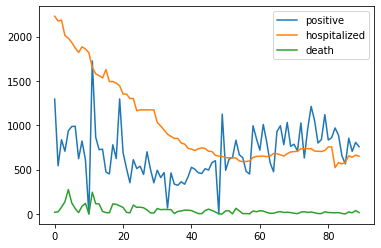

In [70]:

subset_df = political_entity.loc[:,['positive']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'positive')

subset_df = political_entity.loc[:,['hospitalized']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'hospitalized')

subset_df = political_entity.loc[:,['death']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'death')

plt.legend()
plt.show()


# References

- https://www-doh.state.nj.us/doh-shad/view/sharedstatic/CrudeDeathRate.pdf
- https://www.cnn.com/resources/coronavirus-information/19067
